In [1]:
!nvidia-smi

Tue Dec 29 05:19:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

from google.colab import files

from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

!pip install -q requests

In [3]:
import requests

# 設定 GitHub 下戴網址
data_file = 'pkgo_nyc_class5.csv.bz2'
dataset_url = 'https://github.com/hdyen/hands-on-dl/raw/master/PKGO/dataset/'
data_url = '{}{}'.format(dataset_url, data_file)

if not os.path.exists(data_file):
    try:
        r = requests.get(data_url)
        # 將從 GitHub 下戴的資料集寫入 colab 本地端
        with open(data_file, 'wb') as f:
            f.write(r.content)
    except:
        # 如果無法從 GitHub 下戴資料，則自行上傳 pkgo_nyc_class5.csv.bz2
        print('下戴之敗！請將本機端的資料 pkgo_nyc_class5.csv.bz2 上傳到 colab 環境')
        uploaded = files.upload()

pkgo = pd.read_csv(data_file, low_memory=False)

In [4]:
#取八個Columns來做觀察
pd.set_option('display.max_columns', pkgo.shape[-1])
view_list = ['latitude', 'longitude', 'weather',
             'closeToWater', 'terrainType',
             'temperature', 'windSpeed', 'class']

#觀察前十筆資料
pkgo = pkgo[view_list]
pkgo.head(10)

,latitude,longitude,weather,closeToWater,terrainType,temperature,windSpeed,class
0,0.004751,-0.617821,5,0,13,0.398699,-0.575073,1
1,0.073257,-0.703223,5,0,13,0.511728,-0.119994,0
2,0.001167,-0.612492,21,0,13,0.447140,0.021320,1
3,0.208499,-0.532359,5,0,5,-0.231035,-0.254122,1
4,-0.297792,-0.640407,5,1,13,0.689346,0.205747,4
5,-0.297866,-0.640410,5,1,13,0.689346,0.205747,3
6,-0.297744,-0.640399,5,1,13,0.689346,0.205747,4
7,-0.297871,-0.640412,5,1,13,0.689346,0.205747,3
8,0.208481,-0.532345,5,0,5,-0.231035,-0.254122,1
9,-0.297743,-0.640400,5,1,13,0.689346,0.205747,4


### 如何對欄位class做one-hot encoding？
#### class 的值有0,1,2,3,4

In [31]:
pkgo[0:10]['class'].values

array([1, 0, 1, 1, 4, 3, 4, 3, 1, 4])

#### 使用 keras 提供的工具函式 to_categorical 將每筆資料的輸出值 y 轉換成一個向量(one-hot)

In [32]:
y = to_categorical(pkgo['class'])
y[0:10]

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

#### 將 pkgo 切分為訓練神經網路用的特徵值 X 和類別 y


In [33]:
pkgo.shape

(1836, 8)

In [36]:
def Xy_split(pkgo):
  num_cols = pkgo.shape[1]
  # 取class之前的所有features當作特徵值X 做待會的輸入數據
  X = pkgo.iloc[:, :num_cols-1]
  # 取class當作y label
  y = pkgo['class']
  
  # 型別轉換，確保資料型態正確
  X = X.astype(np.float32)
  y = y.astype(np.int)
  
  # 對 y 做 one-hot encoding
  y = to_categorical(y)
  
  # 打亂資料集 (增加亂數性，讓模型訓練更好)
  X, y = shuffle(X, y)
  
  return X, y

X, y = Xy_split(pkgo)
X.shape, y.shape

((1836, 7), (1836, 5))

In [37]:
#切分訓練集與測試集
x_train, y_train, x_test, y_test = X[0:1500], y[0:1500], X[1500::], y[1500::]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1500, 7), (1500, 5), (336, 7), (336, 5))

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/a_single_neuron.png)

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/model_training_tip.png)

# 開始建立第一個模型

In [38]:
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Input
from keras.optimizers import SGD, Adam

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/first_model_setting.png)

## 步驟1+2：設計模型架構 (深度與寬度) & 選擇啟動函數 (activation function)

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/sigmoid_function.png)

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/softmax.png)

In [39]:
#看一下input training dataset 的形狀, 確認資料筆數及欄位數目
x_train.shape

(1500, 7)

In [40]:
# 宣告這是一個 Sequential 次序性的深度學習模型 https://keras.io/zh/getting-started/sequential-model-guide/
model = Sequential()

# 加入第一層 hidden layer (128 neurons) 與指定 input 的維度
model.add(Dense(128, input_dim=x_train.shape[-1]))
model.add(Activation('sigmoid')) # 指定 activation function

# 加入第二層 hidden layer (256 neurons)
model.add(Dense(256))
model.add(Activation('sigmoid'))

# 加入 output layer (5 neurons)
model.add(Dense(5))
model.add(Activation('softmax'))

# 觀察 model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1285      
_________________________________________________________________
activation_2 (Activation)    (None, 5)                 0         
Total params: 35,333
Trainable params: 35,333
Non-trainable params: 0
____________________________________________________

## 步驟 3：選擇損失函數

In [41]:
loss_fun = 'categorical_crossentropy'

## 步驟 4：選擇優化器 (optimizer)

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/SGD_params.png)

In [42]:
from keras.optimizers import SGD

# lr(學習率) - 是一種超參數，它控制了我們在大多程度上調整了我們的網路權重。並對損失梯度進行調整。
# momentum - 動量來源於牛頓第一運動定律，基本思想是為了找到最優加入“慣性”的影響，當誤差曲面中存在平坦區域，SGD可以更快的學習。
# decay - 該方法是為了提高SGD尋優能力，具體就是每次迭代的時候減少學習率的大小。
# nesterov - 是另一種計算梯度的方法，他計算的並非這個位置的梯度而是計算加上了momentum後的位置的梯度（有點類似先偷看了前面的地形再進行更新）

optim = SGD(lr=10e-3, momentum=0.0,
        decay=0.0, nesterov=False)

## 步驟 5：編譯模型

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/model_compile.png)

In [43]:
# 模型在訓練前需要編譯
# 我們指定使用 categorical_crossentropy 當我們的損失函數，
# 指定 SGD 當我們的優化器
# accuracy 當作我們的評估標準
model.compile(loss=loss_fun,
          optimizer=optim,
          metrics=['accuracy'])

## 步驟 6：開始訓練

In [44]:
# 設定 batch_size，訓練迭代輪次(回合數) epochs
batch_size = 32 # 1個mini-batch有32筆資料
epochs = 100

# 開始訓練模型
# https://keras-cn.readthedocs.io/en/latest/models/model/
fitting_history = model.fit(x_train, y_train,     # X為輸入數據、y為標籤
                batch_size=batch_size,  # 一個step的訓練樣本數
                epochs=epochs,      # 將全部數據集看過幾次?
                verbose=1,        # verbose = 1,印出每次訓練過程
                shuffle=True,       # 在每輪迭代開始前打混數據 - (增加亂數性，讓模型訓練更好)
                validation_split=0.2)   # 用在作為驗證集數據的比例20%

Epoch 1/100
38/38 [==============================] - 2s 11ms/step - loss: 1.5880 - accuracy: 0.3768 - val_loss: 1.3642 - val_accuracy: 0.5033
Epoch 2/100
38/38 [==============================] - 0s 4ms/step - loss: 1.3362 - accuracy: 0.5220 - val_loss: 1.3567 - val_accuracy: 0.5033
Epoch 3/100
38/38 [==============================] - 0s 3ms/step - loss: 1.3340 - accuracy: 0.5231 - val_loss: 1.3575 - val_accuracy: 0.5033
Epoch 4/100
38/38 [==============================] - 0s 4ms/step - loss: 1.3342 - accuracy: 0.5206 - val_loss: 1.3499 - val_accuracy: 0.5033
Epoch 5/100
38/38 [==============================] - 0s 3ms/step - loss: 1.3545 - accuracy: 0.4949 - val_loss: 1.3435 - val_accuracy: 0.5033
Epoch 6/100
38/38 [==============================] - 0s 4ms/step - loss: 1.3581 - accuracy: 0.4901 - val_loss: 1.3440 - val_accuracy: 0.5033
Epoch 7/100
38/38 [==============================] - 0s 3ms/step - loss: 1.3052 - accuracy: 0.5266 - val_loss: 1.3414 - val_accuracy: 0.5033
Epoch 8/100


## 繪出訓練結果

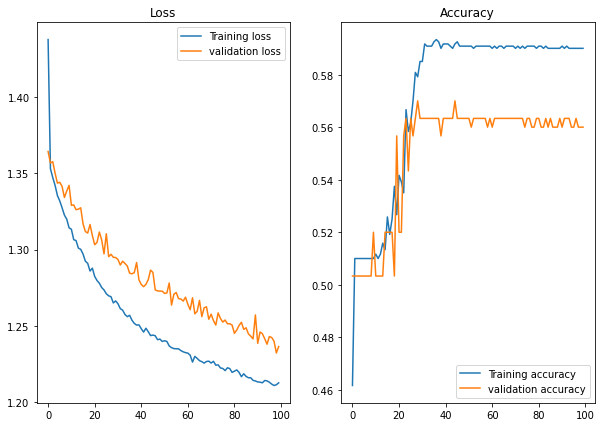

In [45]:
loss = fitting_history.history.get('loss')         # 取出訓練完成後loss的訓練數據
acc = fitting_history.history.get('accuracy')           # 取出訓練完成後accuracy的訓練數據
val_loss = fitting_history.history.get('val_loss') # 取出訓練完成後val_loss的訓練數據
val_acc = fitting_history.history.get('val_accuracy')   # 取出訓練完成後val_accuracy的訓練數據
from pylab import rcParams
rcParams['figure.figsize'] = 10, 7

''' Visualize the loss and accuracy of both models'''
plt.figure(0)

plt.subplot(121)

plt.plot(range(len(loss)), loss, label='Training loss')
plt.plot(range(len(val_loss)), val_loss, label='validation loss')
plt.title('Loss')
plt.legend(loc='upper right')

plt.subplot(122)

plt.plot(range(len(acc)), acc, label='Training accuracy')
plt.plot(range(len(val_acc)), val_acc, label='validation accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [77]:
#evaluate model
pred = model.evaluate(x_test, y_test, verbose=2)

11/11 - 0s - loss: 1.1020 - accuracy: 0.6518


## 進行預測

In [68]:
#取得預測的類別 (機率值最大的那一個類別)
predict=model.predict_classes(x_test)
len(predict)

336

In [69]:
#取得預測各類別的機率值
predict_prob=model.predict(x_test)
predict_prob.shape

(336, 5)

In [50]:
predict_prob[0:5] #只印出前幾筆

array([[0.09630765, 0.46738857, 0.09820275, 0.13536362, 0.20273736],
       [0.12764695, 0.5678102 , 0.08387545, 0.1326633 , 0.08800416],
       [0.17480831, 0.5562266 , 0.10874815, 0.09311991, 0.06709701],
       [0.03900445, 0.20886247, 0.06360799, 0.15493599, 0.53358907],
       [0.16881633, 0.5606831 , 0.1074492 , 0.09365647, 0.06939489]],
      dtype=float32)

In [79]:
predict[0:20] #只印出前幾筆

array([1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1])

In [63]:
y_test[0:5] #只印出前幾筆

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [73]:
predict.shape

(336,)

In [67]:
#取得y_test未進行one-hot encoding的label資料
raw_test_label=[]
for y_onehot in y_test:
  raw_test_label.append(y_onehot.argmax())

raw_test_label[0:5], len(raw_test_label)

([1, 3, 1, 4, 3], 336)

In [78]:
import pandas as pd

pd.crosstab([raw_test_label], predict, rownames=['class'], colnames=['predict'])

predict,1,4
class,,
0,32,1
1,178,7
2,24,1
3,25,15
4,12,41


# 儲存model_weight

In [75]:
model.save_weights('my_model_weights.h5') # HDF5 file

# 匯入model_weight

In [76]:
model.load_weights('my_model_weights.h5')

## 再來瞭解一下，模型訓練有那些元件可以選擇

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/model_training_tip.png)

## 關於Loss function的選擇

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/loss_function_selection.png)

# 關於learning rate的問題

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/learning_rate-1.png)

<hr/>

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/learning_rate-2.png)

## 關於Activate function的選擇

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/activate_func_selection-1.png)

<hr/>

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/activate_func_selection-3.png)

<hr/>

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/activate_func_selection-5.png)

<hr/>

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/activate_func_selection-6.png)

<hr/>

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/activate_func_selection-2.png)

<hr/>

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/activate_func_selection-7.png)

# 關於Optimizer的選擇

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/total_loss.png)

<hr/>

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/Gradient_Descent.png)

<hr/>

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/Gradient_Descent-2.png)

<hr/>

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/Momentum.png)

**一些常見的optimizer最佳化過程的模擬**

![alt text](https://miro.medium.com/max/1240/1*XVFmo9NxLnwDr3SxzKy-rA.gif)

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/optimizer_compare.png)

<hr/>

![alt text](https://gitlab.aiacademy.tw/tclin/at091-DL/raw/master/pic/component_selection_bast_subset.png)